In [251]:
# Add needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Preprocessing
from sklearn.preprocessing import OneHotEncoder

# VIF for multi-collinearity detection
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Models and modeling tools
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm

# Models and modeling tools
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Change inline plots default size
plt.rcParams['figure.figsize'] = [14, 10]

In [253]:
# Read in the rawData
rawData = pd.read_csv('term-deposit-marketing-2020.csv')

# Separate data in independent (features) and dependent (target) datasets
features = rawData.copy()
target = features.pop('y')

# Replace target 'yes'/'no' with 1/0
target.replace({'yes':1,'no':0}, inplace=True)

# Split data initially
x_initial, x_test, y_initial, y_test = train_test_split(features, target, test_size=0.10, random_state=10)
x_train, x_valid, y_train, y_valid = train_test_split(x_initial, y_initial, test_size=0.10, random_state=20)

x_train = x_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
x_valid = x_valid.reset_index(drop=True)
y_valid = y_valid.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [254]:
# Replace binary columns 1/0
for col in ['default', 'housing', 'loan']:
    x_train[col].replace({'yes':1,'no':0}, inplace=True)
    x_valid[col].replace({'yes':1,'no':0}, inplace=True)
    x_test[col].replace({'yes':1,'no':0}, inplace=True)

# Encode small categorical columns
cols = ['marital', 'education', 'contact']

enc = OneHotEncoder(sparse=False, dtype=int)
encodedTrain = enc.fit_transform(x_train[cols])
encodedValid = enc.transform(x_valid[cols])
encodedTest = enc.transform(x_test[cols])

# There has got to be a better way to do this...
encNames = enc.get_feature_names()
for index, item in enumerate(encNames):
    for i in range(len(cols)):
        encNames[index] = encNames[index].replace('x' + str(i), cols[i])

encDFTrain = pd.DataFrame(encodedTrain)
encDFTrain.columns = encNames
encDFValid = pd.DataFrame(encodedValid)
encDFValid.columns = encNames
encDFTest = pd.DataFrame(encodedTest)
encDFTest.columns = encNames

x_train = x_train.drop(columns=cols)
x_train = pd.concat([x_train, encDFTrain], axis=1)
x_valid = x_valid.drop(columns=cols)
x_valid = pd.concat([x_valid, encDFValid], axis=1)
x_test = x_test.drop(columns=cols)
x_test = pd.concat([x_test, encDFTest], axis=1)

# Encode large categorical columns
cols = ['month', 'job']

enc = OneHotEncoder(sparse=False, dtype=int)
encodedTrain = enc.fit_transform(x_train[cols])
encodedValid = enc.transform(x_valid[cols])
encodedTest = enc.transform(x_test[cols])


# There has got to be a better way to do this...
encNames = enc.get_feature_names()
for index, item in enumerate(encNames):
    for i in range(len(cols)):
        encNames[index] = encNames[index].replace('x' + str(i), cols[i])

encDFTrain = pd.DataFrame(encodedTrain)
encDFTrain.columns = encNames
encDFValid = pd.DataFrame(encodedValid)
encDFValid.columns = encNames
encDFTest = pd.DataFrame(encodedTest)
encDFTest.columns = encNames

x_train = x_train.drop(columns=cols)
x_train = pd.concat([x_train, encDFTrain], axis=1)
x_valid = x_valid.drop(columns=cols)
x_valid = pd.concat([x_valid, encDFValid], axis=1)
x_test = x_test.drop(columns=cols)
x_test = pd.concat([x_test, encDFTest], axis=1)

# Oversample the minority set in the training data
oversample = SMOTE()
ovFeatures, ovTarget = oversample.fit_resample(x_train, y_train)

# Remove duration (this is not a reasonable thing to have in the model as it should tell success/failure well?)
#features = features.drop(columns=['duration'])

In [264]:
# Unskew cols
cols = ['balance', 'duration', 'age', 'campaign']
for item in cols:
    shift = x_train[cols].min()
    
    # Shift minimum value to 1 then log them
    x_train[cols] = x_train[cols] - shift + 1
    x_train[cols] = np.log(x_train[cols])
    x_valid[cols] = x_valid[cols] - shift + 1
    x_valid[cols] = np.log(x_valid[cols])
    x_test[cols] = x_test[cols] - shift + 1
    x_test[cols] = np.log(x_test[cols])

In [4]:
## Look at Mutual Information metric to assess weak relationships between features and target
from sklearn.feature_selection import mutual_info_classif

def make_mi_scores(X, y):
    mi_scores = mutual_info_classif(X, y, discrete_features=True)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(ovFeatures, np.ravel(ovTarget))
display (mi_scores)

duration               0.263494
balance                0.105591
contact_unknown        0.071607
marital_married        0.057708
housing                0.049644
month_may              0.046527
job_blue-collar        0.038887
education_secondary    0.037068
loan                   0.031855
education_primary      0.030747
day                    0.025974
month_aug              0.025428
month_jul              0.024716
job_technician         0.023902
month_jun              0.022011
job_services           0.020035
job_management         0.019556
campaign               0.016805
month_nov              0.016341
marital_divorced       0.015802
job_admin              0.015772
age                    0.010956
education_tertiary     0.010951
contact_telephone      0.010228
marital_single         0.009487
month_jan              0.008583
education_unknown      0.008270
job_entrepreneur       0.007731
job_self-employed      0.006891
job_housemaid          0.006827
job_unemployed         0.005437
month_fe

In [5]:
# Look at the skewness of independent variables
features.skew()

age                     0.436080
default                 6.816736
balance                 8.259236
housing                -0.411561
loan                    1.726785
day                     0.067930
duration                3.165307
campaign                4.730901
marital_divorced        2.366427
marital_married        -0.449560
marital_single          1.023505
education_primary       1.888317
education_secondary    -0.099426
education_tertiary      0.979166
education_unknown       4.813341
contact_cellular       -0.506959
contact_telephone       3.781087
contact_unknown         0.776088
month_apr               3.433729
month_aug               2.195556
month_dec              55.445054
month_feb               3.805730
month_jan               5.571914
month_jul               1.860005
month_jun               2.363085
month_mar              12.331125
month_may               0.683557
month_nov               2.866486
month_oct              22.294378
job_admin               2.459527
job_blue-c

In [6]:
# Look at the correlations between independent variables
features.corr()

,age,default,balance,housing,loan,day,duration,campaign,marital_divorced,marital_married,...,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown
age,1.000000,-0.014857,0.081517,-0.179606,0.000041,-0.011689,-0.036270,0.016204,0.161989,0.265630,...,0.027956,0.084920,-0.005302,0.333164,0.001712,-0.057227,-0.155146,-0.058308,0.008052,0.043904
default,-0.014857,1.000000,-0.070069,-0.019229,0.075006,0.006287,-0.008597,0.012135,0.016748,-0.016458,...,0.025645,0.000017,-0.000951,-0.003878,0.004233,-0.003038,-0.013429,-0.004516,0.007232,-0.006397
balance,0.081517,-0.070069,1.000000,-0.049946,-0.080596,0.011662,0.014072,-0.008137,-0.025910,0.023683,...,0.011692,0.003044,0.072172,0.015917,0.015771,-0.033618,0.000575,-0.012655,0.010020,0.010672
housing,-0.179606,-0.019229,-0.049946,1.000000,0.004266,-0.050622,0.022455,-0.054823,-0.004691,0.000680,...,0.003303,-0.086038,-0.067999,-0.112274,-0.032204,0.062391,-0.034034,-0.032180,-0.046197,-0.077605
loan,0.000041,0.075006,-0.080596,0.004266,1.000000,0.005838,-0.003952,0.000582,0.015635,0.032651,...,0.038244,-0.016788,-0.037817,0.017406,-0.008934,0.031939,-0.047512,0.008396,-0.035591,-0.031734
day,-0.011689,0.006287,0.011662,-0.050622,0.005838,1.000000,-0.032983,0.165429,-0.004055,0.005243,...,-0.003629,0.005355,0.026526,-0.002787,0.005080,-0.009461,-0.011183,0.031902,-0.005475,-0.009526
duration,-0.036270,-0.008597,0.014072,0.022455,-0.003952,-0.032983,1.000000,-0.088387,0.007237,-0.029153,...,0.000247,-0.007239,-0.010846,0.001675,0.008821,0.003569,-0.007175,-0.008469,0.017896,-0.007971
campaign,0.016204,0.012135,-0.008137,-0.054823,0.000582,0.165429,-0.088387,1.000000,-0.019951,0.027962,...,-0.002619,0.002804,0.021105,-0.013881,0.004581,-0.010404,-0.008503,0.018915,-0.017052,0.017037
marital_divorced,0.161989,0.016748,-0.025910,-0.004691,0.015635,-0.004055,0.007237,-0.019951,1.000000,-0.457384,...,-0.000406,0.015053,0.010260,0.042143,-0.018049,0.018813,-0.039441,0.013693,0.008317,-0.012932
marital_married,0.265630,-0.016458,0.023683,0.000680,0.032651,0.005243,-0.029153,0.027962,-0.457384,1.000000,...,0.044941,0.046431,-0.036540,0.056708,0.015806,-0.015312,-0.125955,-0.073221,-0.011904,0.014573


In [7]:
# Generate VIF factors for each feature
vif_scores = pd.DataFrame() 
vif_scores["Attribute"] = features.columns 
  
# calculating VIF for each feature 
vif_scores["VIF Scores"] = [variance_inflation_factor(features.values, i) for i in range(len(features.columns))] 
  
display(vif_scores)

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,Attribute,VIF Scores
0,age,1.494822
1,default,1.014831
2,balance,1.054258
3,housing,1.419921
4,loan,1.059531
5,day,1.445083
6,duration,1.017713
7,campaign,1.131206
8,marital_divorced,inf
9,marital_married,inf


In [240]:
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

summaryTab = []
x_train['intercept'] = 1.0
x_valid['intercept'] = 1.0

for col in x_train:
    useCols = ['duration', 'contact_unknown', 'month_mar', 'month_oct', 'marital_divorced', 'job_retired', 'job_student', 'intercept']
    if (col in useCols):
        continue
    #useCols.append(col)
    logReg = sm.Logit(y_train, x_train[useCols])
    result = logReg.fit(disp=False)
    y_pred = logReg.predict(result.params, exog=x_valid[useCols])
    tmp = pd.DataFrame(np.array([y_valid, y_pred.round()]).T, columns=['valid', 'pred'])
    minoritySuccess = 0.0
    if 1.0 in tmp.value_counts()[1.0].keys():
        minoritySuccess = tmp.value_counts()[1.0][1.0]/tmp.value_counts()[1.0].sum()
    summaryTab.append([col, result.pvalues.max(), result.llf, minoritySuccess])
    break
    
tab = pd.DataFrame(summaryTab, columns=['name', 'max_pvalue','llf', 'minoritySuccessRate'])
tab.sort_values(by='minoritySuccessRate', ascending=False)

,name,max_pvalue,llf,minoritySuccessRate
0,age,0.010047,-5453.921721,0.286245


In [243]:
resultSkew = result
resultSkew.params

duration            98.167208
contact_unknown     -1.002892
month_mar            4.072298
month_oct            5.334204
marital_divorced     0.195278
job_retired          0.480624
job_student          1.048565
intercept          -73.708431
dtype: float64

In [244]:
resultSkew.pvalues

duration             0.000000e+00
contact_unknown      3.830029e-56
month_mar           3.301262e-109
month_oct            4.379957e-42
marital_divorced     1.004705e-02
job_retired          6.125131e-05
job_student          9.613888e-10
intercept            0.000000e+00
dtype: float64

In [246]:
#x_test['intercept'] = 1.0
y_predTest = logReg.predict(resultSkew.params, exog=x_test[useCols])

In [247]:
tmp = pd.DataFrame(np.array([y_test, y_predTest.round()]).T, columns=['valid', 'pred'])

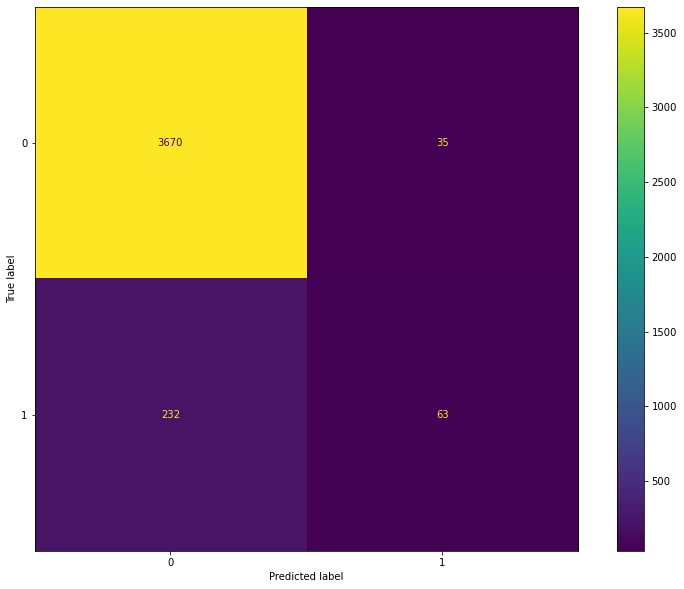

In [248]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_predTest.round())
ConfusionMatrixDisplay(cm).plot()

In [249]:
accuracy_score(y_test, y_predTest.round())

0.93325

In [252]:
balanced_accuracy_score(y_test, y_predTest.round())

0.6020563141883392

In [255]:
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

summaryTab = []
x_train['intercept'] = 1.0
x_valid['intercept'] = 1.0

for col in x_train:
    useCols = ['duration', 'month_oct', 'month_mar', 'month_jun', 'month_jan', 'day', 'job_admin', 'job_housemaid', 'contact_cellular', 'marital_divorced', 'job_student', 'intercept']
    if (col in useCols):
        continue
    #useCols.append(col)
    logReg = sm.Logit(y_train, x_train[useCols])
    result = logReg.fit(disp=False)
    y_pred = logReg.predict(result.params, exog=x_valid[useCols])
    tmp = pd.DataFrame(np.array([y_valid, y_pred.round()]).T, columns=['valid', 'pred'])
    minoritySuccess = 0.0
    if 1.0 in tmp.value_counts()[1.0].keys():
        minoritySuccess = tmp.value_counts()[1.0][1.0]/tmp.value_counts()[1.0].sum()
    summaryTab.append([col, result.pvalues.max(), result.llf, minoritySuccess])
    break
    
tab = pd.DataFrame(summaryTab, columns=['name', 'max_pvalue', 'llf', 'minoritySuccessRate'])
tab.sort_values(by='minoritySuccessRate', ascending=False)

,name,max_pvalue,llf,minoritySuccessRate
0,age,0.026081,-5712.507756,0.32342


In [256]:
resultNoSkew = result
resultNoSkew.pvalues

duration            0.000000e+00
month_oct           8.965920e-62
month_mar           1.237259e-97
month_jun           6.199759e-19
month_jan           1.711584e-12
day                 1.146706e-04
job_admin           2.608113e-02
job_housemaid       4.577176e-05
contact_cellular    3.934176e-70
marital_divorced    1.012386e-02
job_student         1.007805e-10
intercept           0.000000e+00
dtype: float64

In [257]:
resultNoSkew.params

duration            0.004664
month_oct           4.799100
month_mar           3.163325
month_jun           0.934181
month_jan          -1.644131
day                 0.012965
job_admin           0.175932
job_housemaid      -0.840282
contact_cellular    1.346144
marital_divorced    0.197275
job_student         1.064678
intercept          -5.702819
dtype: float64

In [258]:
x_test['intercept'] = 1.0
y_predTest = logReg.predict(resultNoSkew.params, exog=x_test[useCols])

In [259]:
tmp = pd.DataFrame(np.array([y_test, y_predTest.round()]).T, columns=['valid', 'pred'])

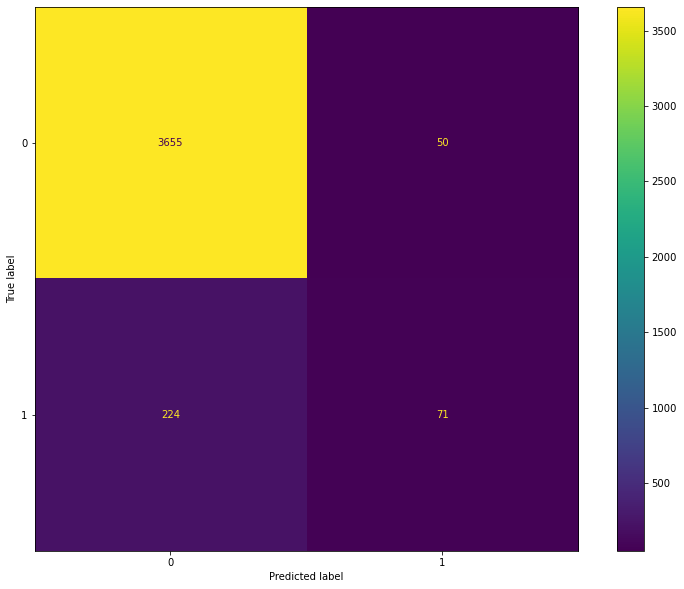

In [260]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_predTest.round())
ConfusionMatrixDisplay(cm).plot()

In [261]:
accuracy_score(y_test, y_predTest.round())

0.9315

In [262]:
balanced_accuracy_score(y_test, y_predTest.round())

0.6135913447242618

<AxesSubplot:xlabel='duration', ylabel='Count'>

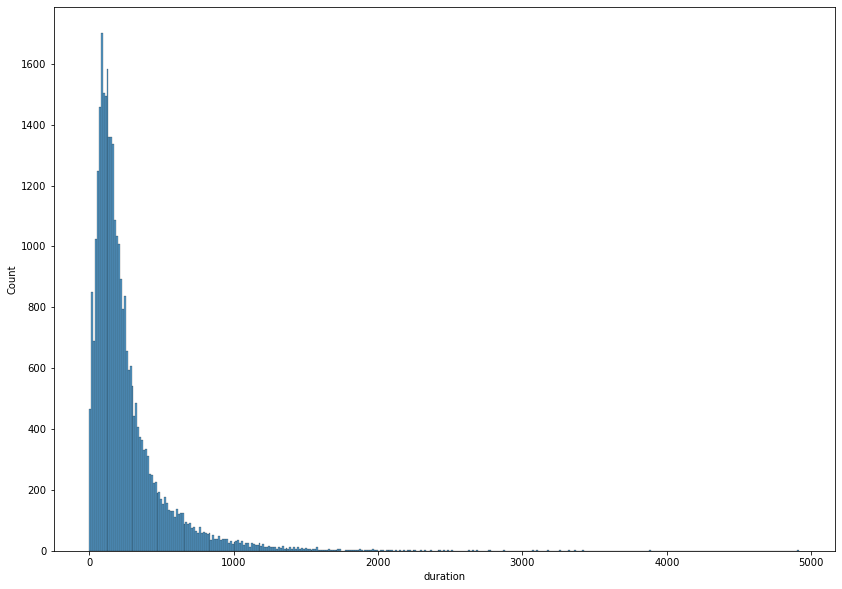

In [263]:
sns.histplot(data=x_train, x='duration')

<AxesSubplot:xlabel='duration', ylabel='Count'>

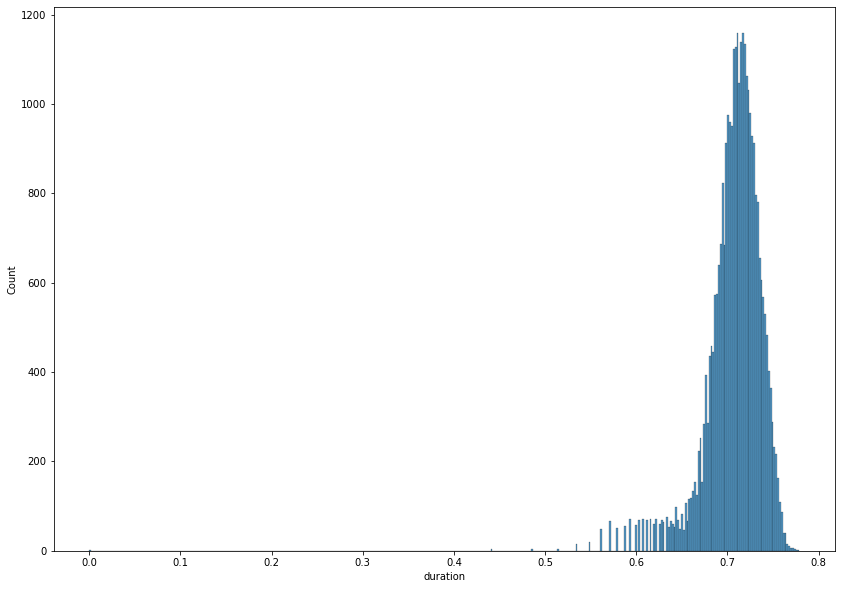

In [265]:
sns.histplot(data=x_train, x='duration')